# Data Wrangling - Deduplicate Data

Load, deduplicate and pickle the Chicago tree trims data. The wrangling of the tree trims dataset is split into two parts to keep the notebook size manageable. This is part two. Part one is located in the `data-wrangling-optimize-verify.ipynb` notebook.

**Project Notebooks Execution Order**
1. [data-wrangling-optimize-verify.ipynb](data-wrangling-optimize-verify.ipynb)
2. data-wrangling-deduplicate.ipynb
3. [exploratory-data-analysis.ipynb](exploratory-data-analysis.ipynb)
4. [forecasting-opened-requests.ipynb](forecasting-opened-requests.ipynb)
5. [forecasting-closed-requests.ipynb](forecasting-closed-requests.ipynb)
6. [summary.ipynb](summary.ipynb)

For a full explanation of this project, see the `README.md` file at the project root or the `summary.ipynb` notebook.

# Import Packages and Modules

In [1]:
import os

from cycler import cycler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Settings

Configure settings for notebook, plots, files and environmental variables. Set `ast_node_interactivity` to display the output of all expressions in a cell so that more than one data frame can be printed at a time in a single cell. Semicolons at the end of `plt.show();` are used in this notebook to suppress the printing of matplotlib objects in cell outputs. Load functions called in notebook.

In [2]:
# Notebook settings
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Plot settings
alpha_mpl = 0.75
color_cycle = ['dodgerblue', '#d5019a', 'midnightblue', 'gray']
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# File settings
data_raw = os.path.abspath('../data/raw/')
data_interim = os.path.abspath('../data/interim/')
data_processed = os.path.abspath('../data/processed/')

# Notebooks with shared functions
%run 'functions-data.ipynb'

# Load Data

## Create Data Frame

In [3]:
df_tt = read_data('Chicago Tree Trims', data_interim, 'chicago-tree-trims.pkl')

Chicago Tree Trims
<class 'pandas.core.frame.DataFrame'>
Int64Index: 360366 entries, 118 to 360483
Data columns (total 12 columns):
creation_date_dt           360366 non-null datetime64[ns]
completion_date_dt         348660 non-null datetime64[ns]
status                     360366 non-null category
service_request_number     360366 non-null object
type_of_service_request    360366 non-null category
location_of_trees          239814 non-null category
street_address             360366 non-null object
zip_code                   360366 non-null int64
community_area             360366 non-null int64
latitude                   360259 non-null float64
longitude                  360259 non-null float64
location                   360259 non-null object
dtypes: category(3), datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 102.3 MB
None




# Duplicates

Review the dataset for duplicated data that can be dropped from the dataset. How many entire rows are duplicated?

In [4]:
print('Number of entire rows that are duplicated: {}'
      .format(df_tt.duplicated().sum()))

Number of entire rows that are duplicated: 0


Duplicates in the dataset are identified in the `status` column with either the "Completed - Dup" value or the "Open - Dup" value. (See https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Tree-Trims/uxic-zsuj.) How many records in the dataset are marked as "Completed - Dup" or the "Open - Dup"?

In [5]:
(df_tt['status'].value_counts().to_frame('count'))

,count
Completed,285606
Completed - Dup,63054
Open,9972
Open - Dup,1734


Next, verify whether or not all duplicates in the dataset are correctly classified as duplicates in the `status` column. Start by checking for possible duplicate Service Request Numbers.

# Duplicated Service Request Numbers (SRNs)

Service Request Numbers (SRNs) identify individual tree trim requests. Its possible that there are duplicate SRNs in the dataset and those duplicates may or may not be correctly classified in the `status` column. Check a few scenarios to confirm whether or not SRN duplicates exist and if they are correctly classified.

## Identified Duplicates

Are there duplicated SRNs in the dataset?

In [6]:
srn_dupes = df_tt[df_tt['service_request_number'].duplicated()].shape[0]
print('Number of duplicated SRNs: {}'.format(srn_dupes))

Number of duplicated SRNs: 1402


What is the `status` value of the duplicated SRNs? Are all duplicated values correctly classified in the `status` column?

In [7]:
(df_tt[df_tt['service_request_number'].duplicated()]['status'].value_counts()
 .to_frame('count'))

,count
Completed,1003
Completed - Dup,399
Open - Dup,0
Open,0


There are duplicated SRNs that are not classified as duplicates. Refer to these duplicates as unidentified duplicates.

## Unidentified Duplicates

Are the unidentified duplicates clustered or spread across the dataset?

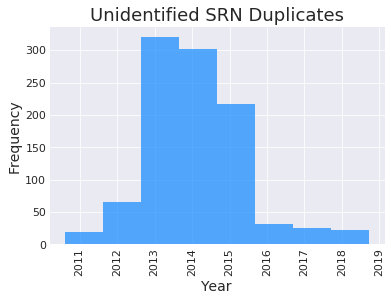

In [8]:
dupe_status = ['Completed - Dup', 'Open - Dup']
mask_dupes_unident = (~(df_tt['status'].isin(dupe_status))
                      & (df_tt['service_request_number'].duplicated(keep='first')))

srn_dupes_dates = df_tt[mask_dupes_unident]['creation_date_dt']

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(mdates.date2num(srn_dupes_dates), bins=8, alpha=alpha_mpl)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title('Unidentified SRN Duplicates')

plt.show();

Unidentified duplicates are primarily clustered in the years 2013-2015. The volume of unidentified duplicates in those years may impact the models, so investigate the unidentified duplicates further to determine if they can be dropped from the dataset.

As for identified duplicates (i.e. `status` values "Completed - Dup" or "Open - Dup"), drop them from the dataset.

In [9]:
print('df_tt shape before: {}'.format(df_tt.shape))
df_tt = df_tt[~df_tt['status'].isin(['Completed - Dup', 'Open - Dup'])]
print('df_tt shape after: {}'.format(df_tt.shape))

df_tt shape before: (360366, 12)
df_tt shape after: (295578, 12)


There isn't any additional information at the Chicago Data Portal (see https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Tree-Trims/uxic-zsuj) about why the SRN duplicates are not identified as duplicates in the dataset. Is there any information in the data that would indicate whether or not the unidentified duplicates can be dropped from the dataset?

### Considerations for Unidentified SRN Duplicates
* When the dataset is grouped by year and month, as it will be for the models, what percentage of the records are duplicates? Do duplicates play a large or small role in the dataset at the month level?
* Are there requests in the dataset that were closed en mass (perhaps suggesting a mass data cleanup effort) and, if so, do the SRN duplicates play a large role in those data spikes?
* How many duplicates are there per SRN? If the size of duplicated groups is three or more, it could complicate the  process of deciding which duplicate to keep.
* Which columns conflict between the duplicated SRNs? (There are likely column that conflict between duplicates as entire rows are not duplicated in the dataset.)
  * Are NaNs in columns causing conflicts between duplicated SRNs?
  * Are there conflicts between the `creation_date_dt` and `completion_date_dt` columns between duplicated SRNs?
  
Setup filters to identify a subset of rows that include all duplicated SRN records, including the first instance of a duplicate, and a subset of rows that ignores the first instance and keeps all subsequent instances of the duplicate. These filters will be used below for cleanup work.

In [10]:
srn_dupes_all = df_tt.duplicated('service_request_number', keep=False)
srn_dupes_all_idx = df_tt[srn_dupes_all].index
srn_dupes_first = df_tt.duplicated('service_request_number', keep='first')
srn_dupes_first_idx = df_tt[srn_dupes_first].index

### Percentage of Duplicates

What percentage of the dataset records are duplicates? Break down the percentage of duplicates by month to understand the impact of duplicates across the dataset. Return the months with the highest rate of duplicates.

In [11]:
print('Percentage of SRN duplicates in the dataset: {:.2%}'
      .format(srn_dupes_first.sum() / df_tt.shape[0]))

Percentage of SRN duplicates in the dataset: 0.33%


The overall percentage of duplicates in the dataset is less than 1%. 

In [12]:
def group_by_date(col, df, idx=None):
    '''Group data frame by year and month.
    
    Parameters
    ----------
    col : str
        Datetime column used to group data frame.
    df : pd.DataFrame
        Data frame to group.
    idx : pd.index, optional
        Index used to filter data frame.
        
    Returns
    -------
    df : pd.DataFrame
        Data frame with DatetimeIndex grouped by year and month and
        count of records per year and month.
    '''
    if idx is not None:
        df = df[df[col].notnull()].loc[idx].set_index(col)
        col_name = 'counts_dupes'
    else:
        df = df[df[col].notnull()].set_index(col)
        col_name = 'counts_all'
    groups = [df.index.year, df.index.month]
    df = df.groupby(groups).size().to_frame(col_name)
    return df

def top_dupes_by_percent(col, df=df_tt, idx=srn_dupes_all_idx):
    '''Return top percentage of duplicates per year and month.
    
    Parameters
    ----------
    col : str
        Datetime column used to group data frame.
    df : pd.DataFrame
        Data frame to group.
    idx : pd.index, optional
        Index used to filter data frame.

    Returns
    -------
    df : pd.DataFrame
        Data frame of top percentage of duplicates per year and month. 
    '''
    df_size = group_by_date(col, df)
    df_dupes = group_by_date(col, df, idx.values)
    df_size = df_size.merge(df_dupes, how='left', left_index=True,
                            right_index=True)
    df_size = df_size.fillna(0)
    df_size['percentage'] = df_size['counts_dupes'] / df_size['counts_all']
    df_size = df_size[df_size['percentage'] > .0099]
    df_size = df_size.style.format({'percentage': '{:.2%}'})
    return df_size

top_dupes_by_percent('creation_date_dt')
top_dupes_by_percent('completion_date_dt')

For a majority of the dataset, the impact of duplicates for any given month is marginal. However, for May 2013, the impact of duplicates for both `completion_date_dt` and `completion_date_dt` variables is high. Also the percentage of duplicate `completion_date_dt` values in November 2014 is nearly 10%. 

### Request Closures En Mass

Are there usually large spikes in request closures and, if so, do the duplicates play a role in those spikes?

Plot the number of closed requests per day to visualize unusual spikes in the closing dates for requests. To smooth out the noise in the line graph below, use a rolling mean (i.e., for every data point, average the data points on either side). Also plot the number of closed requests for unidentified duplicate SRNs.

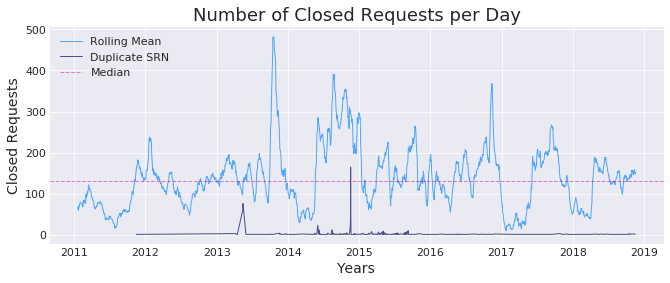

In [13]:
df_comp_date_counts = (df_tt[df_tt['completion_date_dt'].notnull()]
                       .groupby('completion_date_dt')
                       .size()
                       .to_frame('count')
                       .reset_index())
x_1 = df_comp_date_counts['completion_date_dt']
y_1 = df_comp_date_counts['count'].rolling(12).mean()
y_median = df_comp_date_counts['count'].median()

df_srn_dupe = (df_tt[df_tt['completion_date_dt'].notnull()]
               .loc[srn_dupes_first_idx]
               .groupby('completion_date_dt')
               .size()
               .to_frame('count')
               .reset_index())
x_2 = df_srn_dupe['completion_date_dt']
y_2 = df_srn_dupe['count']

fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(x_1, y_1, alpha=alpha_mpl, linewidth=1, label='Rolling Mean')
ax.plot(x_2, y_2, color='C2', alpha=alpha_mpl, linewidth=1, 
         label='Duplicate SRN')
ax.axhline(y_median, color='C1', alpha=0.5, linewidth=1, linestyle='--', 
            label='Median')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Years')
ax.set_ylabel('Closed Requests')
ax.set_title('Number of Closed Requests per Day')
ax.legend(loc='upper left')

plt.show();

Aside for May 2013 and November 2014, as indicated above, duplicated SRNs play only a small role the spikes of closed requests.

### Number of Duplicates per SRN

Group the SRN duplicates and count the number of duplicates per group. What is the range of group sizes?

In [14]:
(df_tt[srn_dupes_all]
 .groupby('service_request_number')
 .size()
 .value_counts()
 .to_frame()
 .reset_index()
 .rename({'index': 'group_size', 0: 'count'}, axis='columns'))

,group_size,count
0,2,962
1,3,4


There are a handful of duplicates SRNs where there are 3 duplicates in a group.

### NaNs

NaNs in columns could be the cause of differences between duplicate SRNs. Out of the duplicate SRNs, which columns contain NaNs? If possible, fill NaN values with populated values from the corresponding SRN duplicate.

In [15]:
df_tt[srn_dupes_all].isnull().sum().to_frame('nan_count')

,nan_count
creation_date_dt,0
completion_date_dt,0
status,0
service_request_number,0
type_of_service_request,0
location_of_trees,859
street_address,0
zip_code,0
community_area,0
latitude,1


How many of the duplicate SRNs with NaNs are in groups of 3? Filling NaN values in groups of three is not as straight forward as doing the same for groups of two. 

In [16]:
s_nan_groups = (df_tt[srn_dupes_all & (df_tt.isnull().any(axis=1))]
                .groupby('service_request_number')
                .size()
                .value_counts())

print('Number of groups with three records and NaN values: {}'
      .format(s_nan_groups.loc[3]))

Number of groups with three records and NaN values: 1


The NaN values in groups of three are isolated to one group. Which columns in that group are NaN?

In [17]:
s_group_three = (df_tt[srn_dupes_all].groupby('service_request_number').size()
                 .loc[lambda x: x == 3].index)
df_tt[(df_tt['service_request_number'].isin(s_group_three))
      & (df_tt.isnull().any(axis=1))].isnull().sum().to_frame('nan_count')

,nan_count
creation_date_dt,0
completion_date_dt,0
status,0
service_request_number,0
type_of_service_request,0
location_of_trees,3
street_address,0
zip_code,0
community_area,0
latitude,0


All of the NaN values are isolated to the `location_of_trees` column, so groups of three don't need any modification. Leave the groups of three out of the filling operation below.

Fill the NaN values where populated values are available. Some groups may contain NaN values in all rows for a particular column.

In [18]:
df_tt.loc[srn_dupes_all_idx] = (df_tt[srn_dupes_all]
                                .groupby('service_request_number')
                                .apply(lambda g: g.bfill().ffill()))

Verify the fill results.

In [19]:
df_tt[srn_dupes_all].isnull().sum().to_frame('nan_count')

,nan_count
creation_date_dt,0
completion_date_dt,0
status,0
service_request_number,0
type_of_service_request,0
location_of_trees,857
street_address,0
zip_code,0
community_area,0
latitude,0


### Diff Rows

Now that the NaN values are filled in, which columns are responsible for the conflict between duplicates and how severe are the conflicts? A combination of the severity level of the conflicts and the importance of the column in the forecasting models will determine whether or not to further wrangle the duplicates. 

Create a boolean data frame that indicates which columns conflict.

In [20]:
def compare_rows(g):
    '''Diff columns between rows.
    
    Within each group, compare the values in the next row against the
    values in the previous row. If the values differ, return True, if
    not, return False.
    
    Parameters
    ----------
    g : group in pandas GroupBy object
        A single group in Pandas GroupBy object.
    
    Returns
    -------
    df_diff : pd.DataFrame
        Data frame of booleans.
    '''
    df_diff = g.ne(g.shift())
    return df_diff

df_diff = (df_tt[srn_dupes_all]
           .sort_values(['service_request_number', 'completion_date_dt'])
           .groupby('service_request_number')
           .apply(lambda g: compare_rows(g)))

Review the results of the last row of each group in df_diff. The last row indicates which columns hold the differences between the rows within groups.  

In [21]:
sort = ['service_request_number', 'completion_date_dt']
srn_dupes_last_idx = (df_tt[srn_dupes_all].reset_index().sort_values(sort)
                      .groupby('service_request_number').last()['index'])

df_diff.loc[srn_dupes_last_idx].sum().to_frame('Diff')

,Diff
creation_date_dt,0
completion_date_dt,966
status,0
service_request_number,0
type_of_service_request,0
location_of_trees,0
street_address,20
zip_code,10
community_area,11
latitude,19


The `completion_date_dt` and `creation_date_dt` columns are important for the forecasting models. The majority of the differences between rows of duplicate SRNs is in the `completion_date_dt` field. There are a minor number of differences in the geolocation related fields. Those geolocation fields are not critical the models and their numbers are low, so leave them as is.

**Created Date and Completed Date Conflicts**

What is the range of differences in days between the completion dates for duplicated SRNs? View the distribution in log scale to visualize the long tail more clearly.

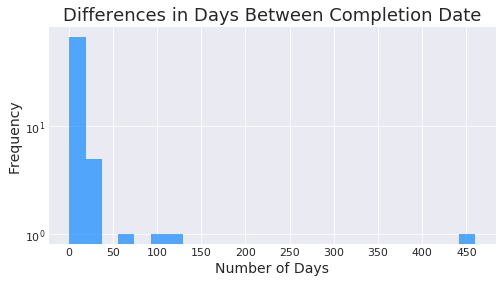

In [22]:
diff_completion = (df_tt[srn_dupes_all]
                   .sort_values(sort)
                   .groupby('service_request_number')
                   ['completion_date_dt']
                   .diff().dt.days
                   .loc[lambda x: x.notnull()]
                   .astype(int)
                   .value_counts())

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(diff_completion, bins=25, alpha=alpha_mpl, log=True)

ax.set_xticks(range(0, diff_completion.max(), 50))
ax.set_xlabel('Number of Days')
ax.set_ylabel('Frequency')
ax.set_title('Differences in Days Between Completion Date')

plt.show();

The majority of the differences in days between conflicting `completion_date_dt` dates fall within a 50 day window with a few outliers. 

### Duplicates Interim Solution

After examining the SRN duplicates from several angles and without a firm conclusion as to why these duplicates are not marked as such in the dataset, the best course of action is to keep the duplicates in the dataset for now. Mark them as duplicates in a new column, fit each model with and without the duplicates and then compare the results between models.

In [23]:
df_tt['is_duplicate'] = False

drop_dupe_idx = (df_tt[srn_dupes_first]
                 .sort_values(['creation_date_dt', 'completion_date_dt'])
                 .index)

df_tt.loc[drop_dupe_idx, 'is_duplicate'] = True
print('Number of SRN duplicates: {}'.format(df_tt['is_duplicate'].sum()))

Number of SRN duplicates: 970


# Export Data

Export data to `/data/processed/` directory. Pickle the data frame to preserve its attributes for reading into subsequent notebooks.

**Chicago Tree Trims**

In [24]:
export_pickle('chicago-tree-trims', df_tt, data_processed)

chicago-tree-trims: (295578, 13)
